### Imports for EDA and Q Learning
***

In [1]:
import pandas as pd
import gym
from gym import spaces
import numpy as np
from math import log2
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from itertools import combinations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

### Read Clicks File
***

In [5]:
clicks_df = pd.read_csv('../data/yoochoose-clicks.dat', 
    delimiter=',',
    usecols=[0,2],
    names=['session_id','item_id'],
    low_memory=True,
    header=None,
    dtype={
        'session_id': 'uint32',
        'item_id': 'uint32',
    }             
)

In [6]:
print('Memory usage: \n',clicks_df.info(memory_usage="deep"))
print('\n''Top 5 rows: \n',clicks_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33003944 entries, 0 to 33003943
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   session_id  uint32
 1   item_id     uint32
dtypes: uint32(2)
memory usage: 251.8 MB
Memory usage: 
 None

Top 5 rows: 
    session_id    item_id
0           1  214536502
1           1  214536500
2           1  214536506
3           1  214577561
4           2  214662742


In [7]:
initial_sessions = clicks_df['session_id'].unique()
print(len(initial_sessions))
initial_items = clicks_df['item_id'].unique()
print(len(initial_items))

9249729
52739


### Keep only sessions that include the top k occuring products
***

In [2]:
k = 500

In [9]:
topk_items = clicks_df['item_id'].value_counts()[0:k]
topk_items =  pd.DataFrame(data=list(topk_items.index), columns=['item_id'])
clicks_df = pd.merge(topk_items, clicks_df, how='left', on='item_id')

In [10]:
duration_frame = clicks_df.groupby('session_id').count()
duration_frame = duration_frame[(duration_frame['item_id'] >=4) & (duration_frame['item_id'] <=10)]
clicks_df = pd.merge(duration_frame, clicks_df, on='session_id', how='left')
clicks_df = clicks_df[['session_id', 'item_id_y']].rename(columns={'item_id_y':'item_id'})
clicks_df.reset_index(inplace=True, drop=True)
del duration_frame

In [3]:
clicks_df.to_csv(f'../data/yoochoose-clicks-compressed-top{k}.csv', index=False)

NameError: name 'clicks_df' is not defined

In [4]:
clicks_df = pd.read_csv(f'../data/yoochoose-clicks-compressed-top{k}.csv')
clicks_df['item_id'] = clicks_df['item_id'].astype('uint16')
clicks_df['session_id'] = clicks_df['session_id'].astype('uint32')

In [5]:
initial_sessions = clicks_df['session_id'].unique()
print(len(initial_sessions))
initial_items = clicks_df['item_id'].unique()
print(len(initial_items))

693804
500


### Cluster Users by Activity
***

In [6]:
users_as_clicks = clicks_df.groupby('session_id')['item_id'].apply(list).reset_index(name='item_id_list')

In [7]:
users_as_clicks['item_id_list'] = users_as_clicks['item_id_list'].apply(lambda x: ' '.join([str(f) for f in x]))

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
x = vectorizer.fit_transform(users_as_clicks['item_id_list'])
reverse_bow_dict = {vectorizer.vocabulary_[k]:k for k in vectorizer.vocabulary_.keys()}

### Find the best Number of Clusters with Elbow Method
***

In [9]:
def perform_clustering(data_to_cluster):
    kmeans = MiniBatchKMeans(random_state=1453,  batch_size=2048, max_iter=1000)
    visualizer = KElbowVisualizer(kmeans, k=(10,21))
    visualizer.fit(data_to_cluster)
    visualizer.show()
    return

def top_k(cluster_center, k=10, lexicon=None):
    if lexicon is None:
        print("Pass something to reverse engineer!\n")
        return
    
    cluster_idx = (-cluster_center).argsort()[:k]
    words_of_importance = [lexicon[f] for f in cluster_idx]
    return words_of_importance


def inspect_clusters(model,data_to_cluster,reverse_dict,n_clusters):
    # Instantiate the clustering model and visualizer
    
    visualizer = InterclusterDistance(model, size=(1080, 720), legend_locstr='upper left', random_state=1453)
    visualizer.fit(data_to_cluster)   
    _ = visualizer.show()        

    for i, cluster_center in enumerate(model.cluster_centers_):
        print("Cluster {} most important dimension indexes...".format(i))
        print(top_k(cluster_center, lexicon=reverse_dict))
        print()
    return

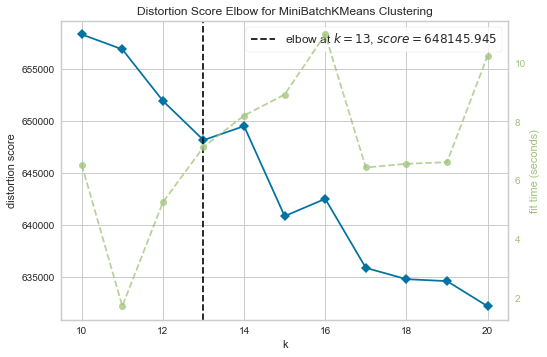

In [159]:
kmeans_model = perform_clustering(data_to_cluster = x)

In [10]:
if k==100:
    best_cluster = MiniBatchKMeans(n_clusters=13, random_state=1453,  batch_size=2048, max_iter=2000).fit(x)
elif k==500:
    best_cluster = MiniBatchKMeans(n_clusters=13, random_state=1453,  batch_size=2048, max_iter=2000).fit(x)
elif k==1000:
    best_cluster = MiniBatchKMeans(n_clusters=13, random_state=1453,  batch_size=2048, max_iter=2000).fit(x)

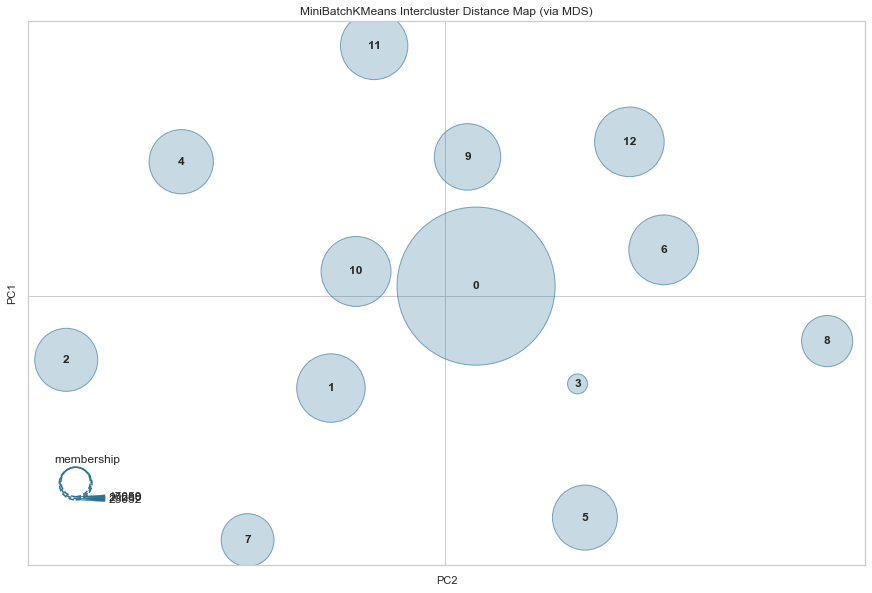

Cluster 0 most important dimension indexes...
['2870', '26412', '2872', '52400', '39568', '23735', '21067', '20735', '2870 2870', '2879']

Cluster 1 most important dimension indexes...
['59833', '59837', '17431', '59830', '52298', '59833 59833', '59869', '59837 59837', '17448', '17386']

Cluster 2 most important dimension indexes...
['26086', '26086 26086', '26082', '24318', '26240', '25970', '26082 24318', '26086 26082', '26082 26082', '24318 24318']

Cluster 3 most important dimension indexes...
['2853', '5709', '2838', '2857', '65194', '2853 2853', '5709 5709', '2838 2838', '9322', '65190']

Cluster 4 most important dimension indexes...
['8009', '8739', '8011', '8737', '22848', '8009 8011', '8009 8009', '8009 8739', '35628', '8011 8739']

Cluster 5 most important dimension indexes...
['26699', '26759', '26690', '26694', '26722', '26692', '26714', '26705', '26699 26690', '26759 26699']

Cluster 6 most important dimension indexes...
['54385', '27350', '54362', '27502', '2463', '26718'

In [19]:
inspect_clusters(best_cluster, x, reverse_dict=reverse_bow_dict, n_clusters=13)

### We pick a cluster that is relatively disjoint and contains enough data
***

In [11]:
cluster_assignment = best_cluster.predict(x)
users_as_clicks['cluster'] = cluster_assignment
if k == 100:
    users_as_clicks = users_as_clicks[users_as_clicks['cluster'] == 12]
elif k == 500:
    users_as_clicks = users_as_clicks[users_as_clicks['cluster'] == 7]
elif k == 1000:
    users_as_clicks = users_as_clicks[users_as_clicks['cluster'] == 12]

clicks_df = pd.merge(clicks_df, users_as_clicks['session_id'], how='right', on='session_id')

item_dict = {v:i for i,v in enumerate(set(clicks_df['item_id'].values))}
session_dict = {v:i for i,v in enumerate(set(clicks_df['session_id'].values))}

clicks_df['session_id'] = clicks_df['session_id'].apply(lambda x: session_dict[x])
clicks_df['item_id'] = clicks_df['item_id'].apply(lambda x: item_dict[x])
clicks_df['item_id'] = clicks_df['item_id'].astype('uint16')
clicks_df['session_id'] = clicks_df['session_id'].astype('uint32')
n_sessions = clicks_df['session_id'].max()
max_q_size = clicks_df['item_id'].max() + 1

In [12]:
initial_sessions = clicks_df['session_id'].unique()
print(len(initial_sessions))
initial_items = clicks_df['item_id'].unique()
print(len(initial_items))

12222
295


### Split into Train / Test
***

In [13]:
SPLIT_RATIO = 0.8
SPLIT_SESSION = round(SPLIT_RATIO * n_sessions - 1)
train_click_df = clicks_df[clicks_df['session_id'] <= SPLIT_SESSION]
test_click_df = clicks_df[clicks_df['session_id'] > SPLIT_SESSION]

In [14]:
initial_train_sessions = train_click_df['session_id'].unique()
print(len(initial_train_sessions))
initial_train_items = train_click_df['item_id'].unique()
print(len(initial_train_items))

9777
280


In [15]:
initial_test_sessions = test_click_df['session_id'].unique()
print(len(initial_test_sessions))
initial_test_items = test_click_df['item_id'].unique()
print(len(initial_test_items))

2445
181


### Environment in OpenAI Format
***

In [22]:
class MooChoose_v1(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size=1, possible_items=90):
        self.window_size = window_size
        self.df = df
        self.current_step = None
        self.session_df = None

        self.current_session = self.min_session = self.df['session_id'].min()
        self.max_session = self.df['session_id'].max()

        self.n_sessions = self.max_session - self.min_session 

        self.n_items = possible_items
        self.action_space = spaces.Discrete(self.n_items)
        self.observation_space = spaces.Discrete(self.n_items)

    def step(self, action):
        self.current_step +=1
        state = self.session_df.loc[ self.current_step : self.current_step+(self.window_size-1),'item_id']
        if state.values[-1] == action:
            reward = 1
        else:
            reward = -1
            
        # Game is done after a step out of bounds
        if self.current_step >= len(self.session_df)- self.window_size:
            done = True
        else:
            done = False

        info = {}

        return state.values, reward, done, info

    def reset(self, debug=False):
        if debug:
            self.current_session = self.min_session
        else:
            self.current_session = self.min_session + ((self.current_session + 1) % self.n_sessions)

        # Get the data points from the current session
        self.session_df = self.df.loc[self.df['session_id'] == self.current_session, ['item_id']].reset_index(drop=True)
        # initialize step to get the first 2 rows
        self.current_step = 0
        return self.session_df.loc[self.current_step : self.current_step +(self.window_size-1),'item_id'].values

### Q Table initialization and Q Table Warmup Function
***

In [23]:
def init_q(s, a, type="ones"):
    """
    @param s the number of states
    @param a the number of actions
    @param type random, ones or zeros for the initialization
    """
    if type == "ones":
        return np.ones((s, a), dtype='float16')
    elif type == "random":
        return np.random.random((s, a), dtype='float16')
    elif type == "zeros":
        return np.zeros((s, a), dtype='float16')

In [24]:
def get_q_warmup(frame, percentage=0.7, max_q_size=295):

    split = round(percentage * frame['session_id'].max() - 1)
    warmup_df = frame[frame['session_id'] < split].copy()

    train_click_df = frame[frame['session_id'] >= split].copy()


    grouped_consecutive_product_ids = warmup_df.groupby(['session_id'])['item_id'].apply(lambda x: [tuple(sorted(pair)) for pair in zip(x,x[1:])]).reset_index()
    df1=pd.DataFrame(grouped_consecutive_product_ids)
    s=df1.item_id.apply(lambda x: pd.Series(x)).unstack()
    df2=pd.DataFrame(s.reset_index(level=0,drop=True)).dropna()
    df2.rename(columns = {0:'Bigram'}, inplace = True)
    df2["freq"] = df2.groupby('Bigram')['Bigram'].transform('count')
    bigram_frequency_consecutive = df2.drop_duplicates(keep="first").sort_values("Bigram").reset_index()
    del bigram_frequency_consecutive["index"]

    Q_bayes = init_q(max_q_size, max_q_size, type="zeros")
    for _, t in bigram_frequency_consecutive.iterrows():
        indexing = t[0]
        freq = t[1]
        Q_bayes[indexing] = freq
    return Q_bayes, train_click_df

### Q Learning Functions
***

In [25]:
def epsilon_greedy(Q, epsilon, n_actions, s, exploit_only=False):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param s number of states
    @param exploit_only if true then no random actions selected
    """
    if exploit_only:
        # Return the best 10 actions
        action = np.argsort(Q[s, :])[::-10]
    elif np.random.rand() > epsilon:
        action = np.argmax(Q[s, :])
    else:
        action = np.random.randint(0, n_actions)
    return action

In [26]:
def qlearning(env, Q,  
                alpha=1,
                gamma=0.5, 
                episodes=50_000, 
                max_steps=10, 
                exploration_decay_rate=0.005, 
                exploit_only=False):
    """
    @param alpha learning rate
    @param gamma decay factor
    @param epsilon for exploration
    @param max_steps for max step in each episode
    @param n_tests number of test episodes
    """
    timestep_reward = []
    # Hit Rate Metrics # 
    hr_at_5 = 0
    hr_at_10 = 0

    # NDCG Metrics #
    ndcg_at_5 = 0
    ndcg_at_10 = 0
    # Engagement Metric #
    eng = 0

    epsilon = 1
    n_states, n_actions = env.observation_space.n, env.action_space.n
    for episode in range(episodes):
        s = env.reset()
        a = epsilon_greedy(Q, epsilon, n_actions, s, exploit_only)
        t = 0
        current_eng = 0
        episode_eng = 0
        total_reward = 0
        done = False
        while t < max_steps:
            t += 1
            if exploit_only is True:
                s_, reward, done, info = env.step(a[0][0])
                # This iterates over the proposed actions
                # And calculates if the true action s_
                # Is in one of the 5 or 10 proposed
                for index, proposed_action in enumerate(a[0]):
                    if s_ == proposed_action:
                        if index == 0:
                            current_eng += 1
                        if index < 5:
                            hr_at_5 += 1
                            ndcg_at_5 += (1.0 / log2(2+index))
                        hr_at_10 += 1
                        ndcg_at_10 += (1.0 / log2(2+index))
                    else:
                        pass 
                if current_eng > episode_eng:
                    episode_eng = current_eng              
            else:
                s_, reward, done, info = env.step(a)

            total_reward += reward
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_, exploit_only)
            if exploit_only is False:
                # If we are not in test phase
                # This is the Q table update function
                if done:
                    Q[s, a] += alpha * ( reward  - Q[s, a] )
                else:
                    Q[s, a] += alpha * ( reward + (gamma * Q[s_, a_]) - Q[s, a] )
            else:
                pass

            s, a = s_, a_
            if done:
                timestep_reward.append(total_reward / t)
                epsilon = max(0.0 , np.exp(-exploration_decay_rate / 100 * episode))
                eng += episode_eng  
                break
    return timestep_reward, Q, hr_at_5, hr_at_10, ndcg_at_5, ndcg_at_10, eng

### Experiment 1: Warmup On 70% + Q Learning
***

In [27]:
### Training
Q_bayes, experiment_1_train_df = get_q_warmup(train_click_df, percentage=0.7, max_q_size=max_q_size)
env = MooChoose_v1(experiment_1_train_df, window_size=1, possible_items=max_q_size)
t, Q, _, _, _, _, _ = qlearning(env=env, Q=Q_bayes, alpha = 1, gamma = 0.5, episodes = 30_000, max_steps = 10, exploration_decay_rate=0.05)

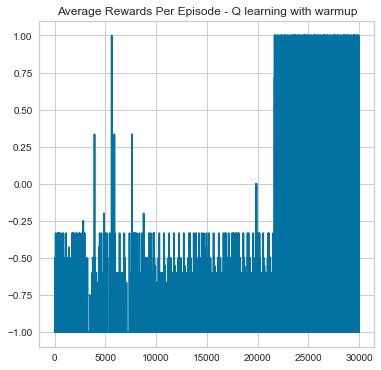

In [28]:
plt.figure(figsize=(6,6))
plt.title("Average Rewards Per Episode - Q learning with warmup")
plt.plot(t)
plt.show()

In [29]:
### Testing
env = MooChoose_v1(test_click_df, window_size=1, possible_items=max_q_size)
test_episodes = test_click_df['session_id'].max() - test_click_df['session_id'].min() + 1
test_clicks = test_click_df.shape[0]
p, _, hr_at_5, hr_at_10, ndcg_at_5, ncdg_at_10, eng = qlearning(env=env, Q=Q,  episodes = test_episodes, exploit_only=True)

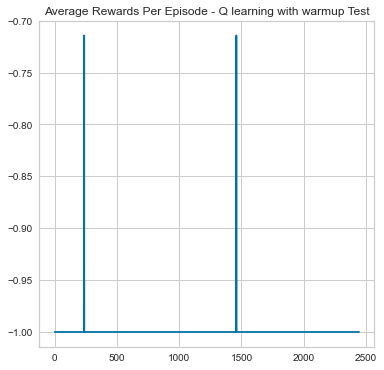

In [30]:
plt.figure(figsize=(6,6))
plt.title("Average Rewards Per Episode - Q learning with warmup Test")
plt.plot(p)
plt.show()

In [31]:
print(f"Test results: \n HR_5: {round(100 *hr_at_5/test_clicks,2)} \n HR_10: {round(100 *hr_at_10/test_clicks,2)} \n NDCG_5: {round(100 * ndcg_at_5/test_clicks,2)} \n NDCG_10: {round( 100*ncdg_at_10/test_clicks,2)} \n ENG: {round(100*eng/test_clicks,2)}")

Test results: 
 HR_5: 0.15 
 HR_10: 80.46 
 NDCG_5: 0.09 
 NDCG_10: 11.7 
 ENG: 0.02


### Experiment 2: No Warmup Q Learning
***

In [32]:
### Training
del Q_bayes
del Q


Q = init_q(max_q_size, max_q_size, type="zeros")
env = MooChoose_v1(train_click_df, window_size=1, possible_items=max_q_size)
t, Q, _, _, _, _, _ = qlearning(env=env, Q=Q, alpha = 1, gamma = 0.5, episodes = 30_000, max_steps = 10, exploration_decay_rate=0.05)

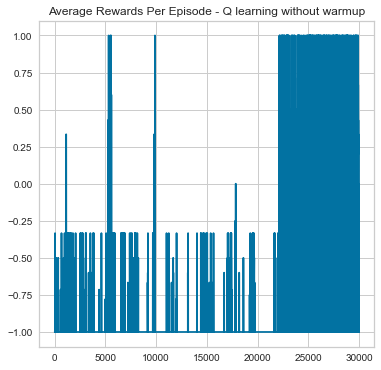

In [33]:
plt.figure(figsize=(6,6))
plt.title("Average Rewards Per Episode - Q learning without warmup")
plt.plot(t)
plt.show()

In [34]:
### Testing
env = MooChoose_v1(test_click_df, window_size=1, possible_items=max_q_size)

test_clicks = test_click_df.shape[0]
test_episodes = test_click_df['session_id'].max() - test_click_df['session_id'].min() + 1

p, _, hr_at_5, hr_at_10, ndcg_at_5, ncdg_at_10, eng = qlearning(env=env, Q=Q,  episodes=test_episodes, exploit_only=True)

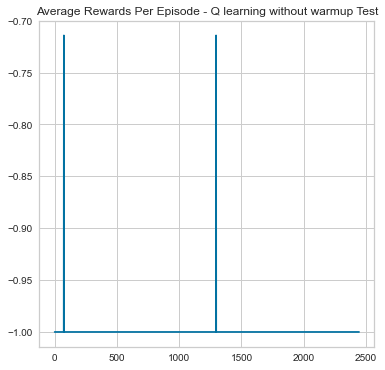

In [35]:
plt.figure(figsize=(6,6))
plt.title("Average Rewards Per Episode - Q learning without warmup Test")
plt.plot(p)
plt.show()

In [36]:
print(f"Test results: \n HR_5: {round(100 *hr_at_5/test_clicks,2)} \n HR_10: {round(100 *hr_at_10/test_clicks,2)} \n NDCG_5: {round(100 * ndcg_at_5/test_clicks,2)} \n NDCG_10: {round( 100*ncdg_at_10/test_clicks,2)} \n ENG: {round(100*eng/test_clicks,2)}")

Test results: 
 HR_5: 0.05 
 HR_10: 80.46 
 NDCG_5: 0.03 
 NDCG_10: 12.85 
 ENG: 0.02


### Deep Reinforcement Learning Imports
***

In [37]:
## pip install keras-rl2 example : https://github.com/wau/keras-rl2/blob/master/examples/dqn_cartpole.py

In [38]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [39]:
from rl.agents.dqn import DQNAgent
from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy, GreedyQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

### Deep Learning Evaluation Methods
***

In [40]:
def convert_state_to_model_input(state):
    state = state.reshape(1, 1,-1)
    return state

def forward_pass(model, state):
    state = convert_state_to_model_input(state)
    predictions = model.predict(state)
    top_10_predictions = np.argsort(predictions[0])[::-10]
    return top_10_predictions
    
def deep_qlearning_evaluation(env, model, test_episodes):
    # Keep a counter on total number of test clicks #
    n_clicks = 0

    # Hit Rate Metrics # 
    hr_at_5 = 0
    hr_at_10 = 0

    # NDCG Metrics #
    ndcg_at_5 = 0
    ndcg_at_10 = 0

    # Engagement Metric #
    eng = 0

    n_states, n_actions = env.observation_space.n, env.action_space.n
    for episode in range(test_episodes):
        s = env.reset()
        a = forward_pass(model, s)
        t = 0
        current_eng = 0
        episode_eng = 0
        done = False
        while t < 10:
            n_clicks += 1
            t += 1
            s_, reward, done, info = env.step(a[0])

            # This iterates over the proposed actions
            # And calculates if the true action s_
            # Is in one of the 5 or 10 proposed
            for index, proposed_action in enumerate(a):
                if s_[-1] == proposed_action:
                    if index == 0:
                        current_eng += 1
                    if index < 5:
                        hr_at_5 += 1
                        ndcg_at_5 += (1.0 / log2(2+index))
                    hr_at_10 += 1
                    ndcg_at_10 += (1.0 / log2(2+index))
                else:
                    pass
            if current_eng > episode_eng:
                episode_eng = current_eng          
            a_ = forward_pass(model, s_)
            s, a = s_, a_
            if done:
                eng += episode_eng
                break
    return round(100* hr_at_5 / n_clicks, 2), round(100 * hr_at_10 / n_clicks,2), round(100* ndcg_at_5 / n_clicks,2), round(100*ndcg_at_10 / n_clicks,2), round(eng / n_clicks,2)

### Deep Reinforcement Learning Methods
#### Method 1: Deep Sarsa 
***

In [96]:
window_size = 3
env = MooChoose_v1(train_click_df, window_size=window_size, possible_items=max_q_size)
n_states, n_actions = env.observation_space.n, env.action_space.n

model_dsarsa = Sequential()
model_dsarsa.add(Flatten(input_shape=(1,) + (window_size,)))
model_dsarsa.add(Embedding(n_states+1, 64, input_length=window_size))
model_dsarsa.add(LSTM(128, return_sequences=False))
model_dsarsa.add(Dense(100, activation='relu'))
model_dsarsa.add(Dense(n_actions, activation='linear'))



# SARSA does not require a memory.
policy = EpsGreedyQPolicy(eps=0.1)
sarsa_agent = SARSAAgent(model=model_dsarsa, nb_actions=n_actions, nb_steps_warmup=0, policy=policy)
sarsa_agent.compile(Adam(lr=1e-3), metrics=['mae'])

In [97]:
model_dsarsa.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3)                 0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 3, 64)             18944     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_11 (Dense)             (None, 295)               29795     
Total params: 160,455
Trainable params: 160,455
Non-trainable params: 0
_________________________________________________________________


In [98]:
history_sarsa = sarsa_agent.fit(env, nb_steps=30_000, visualize=False, verbose=0)

C:\ProgramData\Anaconda3\envs\rapid\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


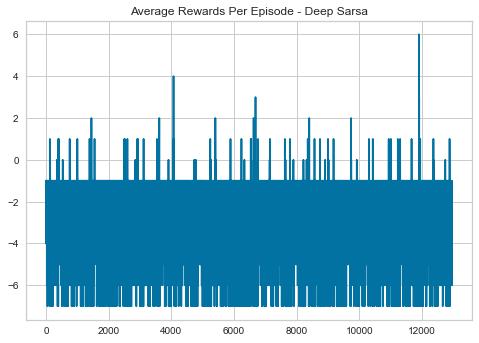

In [99]:
er = history_sarsa.history['episode_reward']

plt.figure()
plt.title('Average Rewards Per Episode - Deep Sarsa')
plt.plot(er)
plt.show()

In [145]:
window_size = 3
env = MooChoose_v1(test_click_df, window_size=window_size, possible_items=max_q_size)
test_episodes = test_click_df['session_id'].max() - test_click_df['session_id'].min() + 1

sarsa_agent.test(env, nb_episodes=test_episodes, visualize=False)

 1933: reward: -2.000, steps: 2
Episode 1934: reward: -1.000, steps: 1
Episode 1935: reward: -2.000, steps: 2
Episode 1936: reward: -6.000, steps: 6
Episode 1937: reward: -1.000, steps: 1
Episode 1938: reward: -5.000, steps: 5
Episode 1939: reward: -2.000, steps: 2
Episode 1940: reward: -1.000, steps: 1
Episode 1941: reward: -1.000, steps: 1
Episode 1942: reward: -1.000, steps: 1
Episode 1943: reward: -6.000, steps: 6
Episode 1944: reward: -3.000, steps: 3
Episode 1945: reward: -1.000, steps: 1
Episode 1946: reward: -1.000, steps: 1
Episode 1947: reward: -5.000, steps: 5
Episode 1948: reward: -3.000, steps: 3
Episode 1949: reward: -1.000, steps: 1
Episode 1950: reward: -7.000, steps: 7
Episode 1951: reward: -1.000, steps: 1
Episode 1952: reward: -4.000, steps: 4
Episode 1953: reward: -1.000, steps: 1
Episode 1954: reward: -3.000, steps: 3
Episode 1955: reward: -1.000, steps: 1
Episode 1956: reward: -4.000, steps: 4
Episode 1957: reward: -2.000, steps: 2
Episode 1958: reward: -2.000, st

In [137]:
### Extract the Agent Model and save it
model_dsarsa.save('dsarsa_agent_k500_full.h5')

In [140]:
hr_at_5, hr_at_10, ndcg_at_5, ndcg_at_10, eng = deep_qlearning_evaluation(env, model_dsarsa, test_episodes)
print(f"Test results: \n HR_5: {hr_at_5} \n HR_10: {hr_at_10} \n NDCG_5: {ndcg_at_5} \n NDCG_10: {ndcg_at_10} \n ENG: {eng}")

Test results: 
 HR_5: 0.1 
 HR_10: 9.6 
 NDCG_5: 0.05 
 NDCG_10: 2.31 
 ENG: 0.0


### Deep Reinforcement Learning Methods
#### Method 2: Deep Q Learning with Time Window 
***

#### Pretraining Funtions and Data Generation


In [60]:
def generate_embedding_pretraining_data(train_click_df, window_size, max_q_size):
    sequences = []
    labels = []
    for f in train_click_df.groupby('session_id')['item_id'].apply(list).values:
        need_to_pad = 10 - len(f)
        sequence = f + ([max_q_size] * need_to_pad) 
        
        for ii in range(0,  9 - window_size):
            train_sequence = sequence[ii:ii+window_size]
            label_of_sequence = sequence[ii+window_size+1]
            sequences.append(train_sequence)
            labels.append(label_of_sequence)
    return sequences, labels

In [61]:
sequences, labels = generate_embedding_pretraining_data(train_click_df, 3, max_q_size)

In [62]:
x_train = np.array(sequences)
y_train = np.array(labels)

#### Pretrain Embeddings and Base Network of DQN (NWP task)

In [63]:
window_size = 3
env = MooChoose_v1(train_click_df, window_size=window_size, possible_items=max_q_size)
n_states, n_actions = env.observation_space.n, env.action_space.n

In [64]:
model_input = Input(shape=(window_size,))

x = Embedding(n_states+1, 64, input_length=window_size, name='Emb_Layer')(model_input)
x = LSTM(units=128, return_sequences=False, name='LSTM_Layer')(x)
x = Dense(100, activation='relu', name='Dense_Layer')(x)
x = Dropout(rate=0.3)(x)
model_output = Dense(n_states+1, activation='softmax')(x)

model = Model(inputs=[model_input], outputs=[model_output])

In [65]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
Emb_Layer (Embedding)        (None, 3, 64)             18944     
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 128)               98816     
_________________________________________________________________
Dense_Layer (Dense)          (None, 100)               12900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 296)               29896     
Total params: 160,556
Trainable params: 160,556
Non-trainable params: 0
_____________________________________________________

In [66]:
model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
model.fit(x_train, y_train, batch_size=256, epochs=10, validation_split=0.2)

Train on 46929 samples, validate on 11733 samples
Epoch 1/10
46848/46929 [============================>.] - ETA: 0s - loss: 1.6613 - accuracy: 0.7738C:\ProgramData\Anaconda3\envs\rapid\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
46929/46929 [==============================] - 5s 106us/sample - loss: 1.6598 - accuracy: 0.7738 - val_loss: 0.9362 - val_accuracy: 0.7841
Epoch 2/10
46929/46929 [==============================] - 4s 94us/sample - loss: 0.9522 - accuracy: 0.7795 - val_loss: 0.9184 - val_accuracy: 0.7841
Epoch 3/10
46929/46929 [==============================] - 4s 94us/sample - loss: 0.9077 - accuracy: 0.7793 - val_loss: 0.8692 - val_accuracy: 0.7841
Epoch 4/10
46929/46929 [==============================] - 4s 92us/sam

#### Get the Embeddings, LSTM and Dense Layer and use them in the Reinforcment Learning Agent

In [68]:
embedding_layer = model.get_layer('Emb_Layer')
lstm_layer = model.get_layer('LSTM_Layer')
dense_layer = model.get_layer('Dense_Layer')

In [69]:
window_size = 3
env = MooChoose_v1(train_click_df, window_size=window_size,possible_items=max_q_size)
n_states, n_actions = env.observation_space.n, env.action_space.n

memory = SequentialMemory(limit=10_000, window_length=1)

model_dqn = Sequential()
model_dqn.add(Flatten(input_shape=(1,) + (window_size,)))
model_dqn.add(embedding_layer)
model_dqn.add(lstm_layer)
model_dqn.add(dense_layer)
model_dqn.add(Dense(n_actions, activation='linear'))

policy = EpsGreedyQPolicy(eps=0.1)
dqn = DQNAgent(model=model_dqn, nb_actions=n_actions, policy=policy, memory=memory,
               nb_steps_warmup=200, gamma=0.5, target_model_update=500)

dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [70]:
model_dqn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3)                 0         
_________________________________________________________________
Emb_Layer (Embedding)        (None, 3, 64)             18944     
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 128)               98816     
_________________________________________________________________
Dense_Layer (Dense)          (None, 100)               12900     
_________________________________________________________________
dense_9 (Dense)              (None, 295)               29795     
Total params: 160,455
Trainable params: 160,455
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = dqn.fit(env, nb_steps=30_000, visualize=False, verbose=0)

C:\ProgramData\Anaconda3\envs\rapid\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\ProgramData\Anaconda3\envs\rapid\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


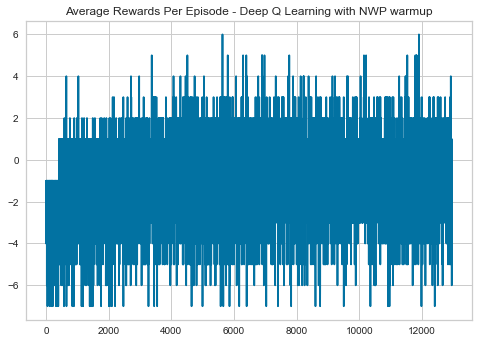

In [95]:
er = history.history['episode_reward']

plt.figure()
plt.title('Average Rewards Per Episode - Deep Q Learning with NWP warmup')
plt.plot(er)
plt.show()

In [81]:
window_size = 3
env = MooChoose_v1(test_click_df, window_size=window_size, possible_items=max_q_size)
test_episodes = test_click_df['session_id'].max() - test_click_df['session_id'].min() + 1

l=dqn.test(env, nb_episodes=test_episodes, visualize=False)

 2.000, steps: 2
Episode 1928: reward: -4.000, steps: 4
Episode 1929: reward: -1.000, steps: 1
Episode 1930: reward: -1.000, steps: 1
Episode 1931: reward: -2.000, steps: 4
Episode 1932: reward: 1.000, steps: 1
Episode 1933: reward: -2.000, steps: 2
Episode 1934: reward: -1.000, steps: 1
Episode 1935: reward: 0.000, steps: 2
Episode 1936: reward: 0.000, steps: 6
Episode 1937: reward: 1.000, steps: 1
Episode 1938: reward: -1.000, steps: 5
Episode 1939: reward: -2.000, steps: 2
Episode 1940: reward: 1.000, steps: 1
Episode 1941: reward: -1.000, steps: 1
Episode 1942: reward: -1.000, steps: 1
Episode 1943: reward: -6.000, steps: 6
Episode 1944: reward: 1.000, steps: 3
Episode 1945: reward: -1.000, steps: 1
Episode 1946: reward: 1.000, steps: 1
Episode 1947: reward: -1.000, steps: 5
Episode 1948: reward: 3.000, steps: 3
Episode 1949: reward: -1.000, steps: 1
Episode 1950: reward: -1.000, steps: 7
Episode 1951: reward: -1.000, steps: 1
Episode 1952: reward: 0.000, steps: 4
Episode 1953: rew

In [106]:
### Extract the Agent Model and save it
model_dqn.save('dqn_agent_k500_full.h5')

In [127]:
window_size = 3
env = MooChoose_v1(test_click_df, window_size=window_size, possible_items=max_q_size)
test_episodes = test_click_df['session_id'].max() - test_click_df['session_id'].min() + 1

hr_at_5, hr_at_10, ndcg_at_5, ndcg_at_10, eng = deep_qlearning_evaluation(env, model_dqn, test_episodes)
print(f"Test results: \n HR_5: {hr_at_5} \n HR_10: {hr_at_10} \n NDCG_5: {ndcg_at_5} \n NDCG_10: {ndcg_at_10} \n ENG: {eng}")